In [1]:
import torch
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig

from utils import pic2float

In [87]:
# BLIP = "Salesforce/blip2-flan-t5-xl"
# BLIP = "Salesforce/blip2-flan-t5-base"
# BLIP = "Salesforce/blip2-opt-6.7b-coco"
BLIP = "Salesforce/blip2-opt-2.7b"

class BlipImageCaptioner:
    def __init__(self, 
                 device: str = "cuda", 
                 model_name: str = BLIP, 
                 processor_name: str = BLIP,                 
                 prompt: str = "Question: Describe the main (central) object in this image. Answer:",
                 # prompt: str = 'Focus on the single most prominent object in the center of the photo. What is it?'
    ):
        self.device = device
        
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,                # включаем 4-битную квантизацию
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=False,
            bnb_4bit_quant_type="nf4"         # можно попробовать и другие варианты, например 'fp4'
        )
        
        self.processor = Blip2Processor.from_pretrained(
            model_name,
        )
        self.model = Blip2ForConditionalGeneration.from_pretrained(
            processor_name,
            torch_dtype=torch.float16,     
            quantization_config=quant_config 
        ).to(device)
        self.prompt = prompt

    def describe_central_object(self, image) -> str:
        # raw_image = Image.open(image_path).convert("RGB")
        image = pic2float(image)
        prompt = self.prompt
        inputs = self.processor(image, prompt, return_tensors="pt", do_rescale=False).to(self.device)

        with torch.no_grad():
            out = self.model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=True,
                top_p=0.9,
                temperature=0.7
            )

        caption = self.processor.decode(out[0], skip_special_tokens=True)
        answer_idx = caption.find("Answer:") + len("Answer: ")
        return caption[answer_idx:]


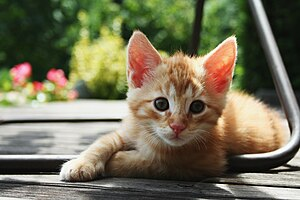

In [2]:
test_image = "../image.jpg"
test_image = Image.open(test_image).convert("RGB")
test_image

In [88]:
captioner = BlipImageCaptioner()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [89]:

txt = captioner.describe_central_object(test_image)
txt

'A small orange tabby kitten lying on a wooden deck\n'

In [ ]:
import torch
from transformers import GroundingDinoProcessor, GroundingDinoForObjectDetection
from torch.amp import autocast

device = "cuda" if torch.cuda.is_available() else "cpu"
text = "a cat"
detector_id = "IDEA-Research/grounding-dino-tiny"

In [93]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

class GDINO:
    def __init__(self, model_id = "IDEA-Research/grounding-dino-base", device = "cuda"):
        self.device = device
        
        # quant_config = BitsAndBytesConfig(
        #     load_in_4bit=True,                # включаем 4-битную квантизацию
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=False,
        #     bnb_4bit_quant_type="nf4"         # можно попробовать и другие варианты, например 'fp4'
        # )
        
        self.processor = GroundingDinoProcessor.from_pretrained(detector_id)
        self.model = GroundingDinoForObjectDetection.from_pretrained(
            detector_id,
            torch_dtype=torch.float16,
        ).to(device)
        
    def detect_objects(self, image, text='a cat'):
        image = pic2float(image)
        text = preprocess_caption(text)
        inputs = self.processor(
            image, 
            return_tensors="pt", 
            text=text, 
            do_rescale=False
        ).to(self.device)
        
        with torch.no_grad():
            with autocast('cuda', dtype=torch.float16):
                outputs = self.model(**inputs)
        
        results = self.processor.image_processor.post_process_object_detection(
            outputs,
            target_sizes=[image.shape[:-1]],
            threshold=0.1
        )[0]
        return results
        
gdino = GDINO()

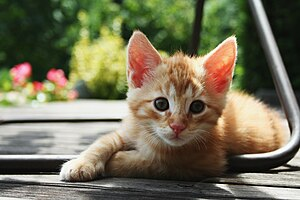

In [22]:
image = pic2float(test_image)
test_image

In [116]:
results = gdino.detect_objects(image, txt)
results

{'scores': tensor([0.8356, 0.2487, 0.2278, 0.1172, 0.1785, 0.1272, 0.1515, 0.1122, 0.1375,
         0.1036], device='cuda:0'),
 'labels': tensor([ 4, 11, 10, 11, 11, 11, 11, 11, 11, 11], device='cuda:0'),
 'boxes': tensor([[ 5.8209e+01,  2.9224e+01,  2.9198e+02,  1.8345e+02],
         [ 6.3747e-02,  1.4788e+02,  3.0006e+02,  1.9997e+02],
         [ 8.1450e-02,  9.5221e+01,  3.0008e+02,  1.9992e+02],
         [ 3.9697e-02,  9.3377e-02,  3.0004e+02,  2.0008e+02],
         [-2.4319e-03,  1.3482e+02,  3.0000e+02,  1.9994e+02],
         [ 5.4181e-02,  8.1071e+01,  3.0005e+02,  2.0007e+02],
         [ 3.6192e-02,  1.1319e+02,  3.0004e+02,  1.9984e+02],
         [-3.2249e-02,  1.6339e+02,  2.9997e+02,  2.0008e+02],
         [ 5.9491e-02,  1.7155e+02,  3.0006e+02,  1.9998e+02],
         [-3.8543e-02,  2.7793e+01,  2.9996e+02,  1.9955e+02]], device='cuda:0')}

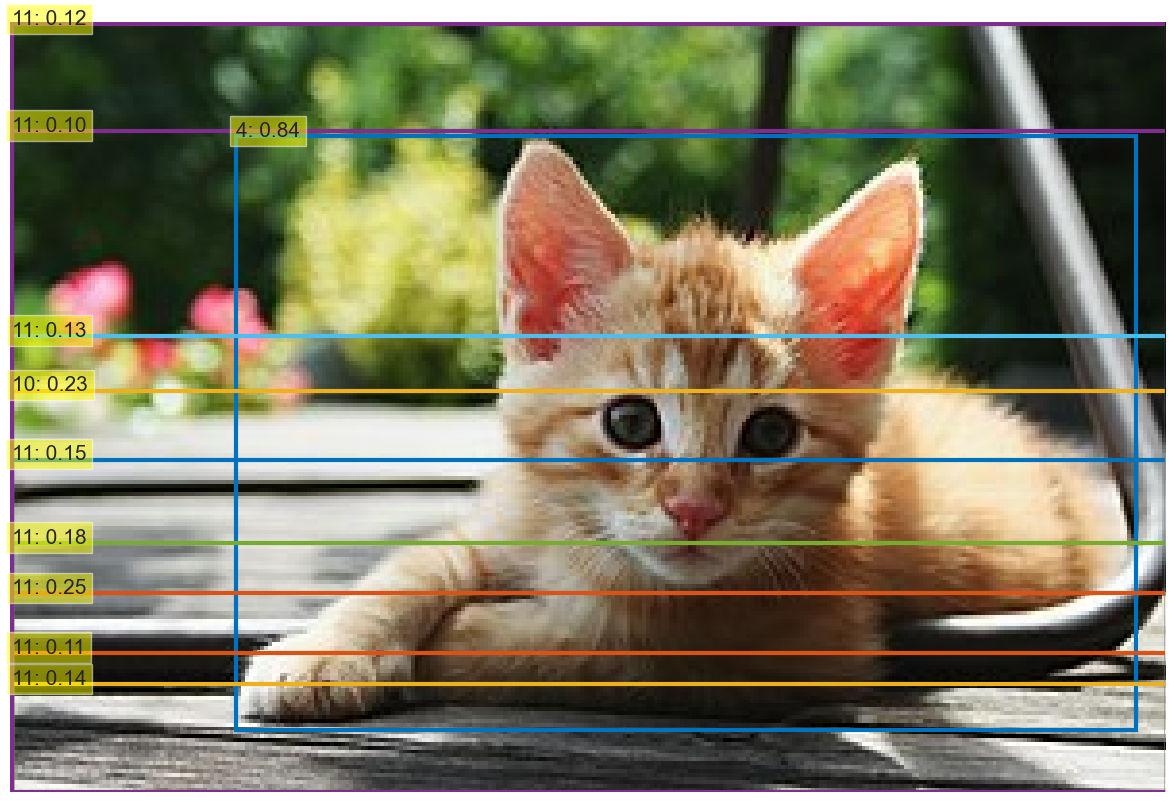

In [118]:
n = 10
plot_results(image, results, n)

In [112]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, results, n=2):
    scores = results['scores'].tolist()[:n]
    labels = results['labels'].tolist()[:n]
    boxes = results['boxes'].tolist()[:n]
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        # label = f'{text}: {score:0.2f}'
        label = f'{label}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [70]:


results = postprocessed_outputs[0]

In [82]:
postprocessed_outputs

[{'scores': tensor([0.7144, 0.1412, 0.1082, 0.1058, 0.1018, 0.1080], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2, 2], device='cuda:0'),
  'boxes': tensor([[ 58.0257,  28.9406, 290.7420, 183.2856],
          [ 97.5626,  34.1601, 244.9881, 178.6873],
          [117.8525,  38.4608, 235.7811, 172.5995],
          [ 22.3836,  11.5655, 299.3005, 196.3818],
          [ 99.5147,  29.6131, 250.4906, 192.4753],
          [105.4180,  30.9410, 240.3815, 195.1736]], device='cuda:0')}]

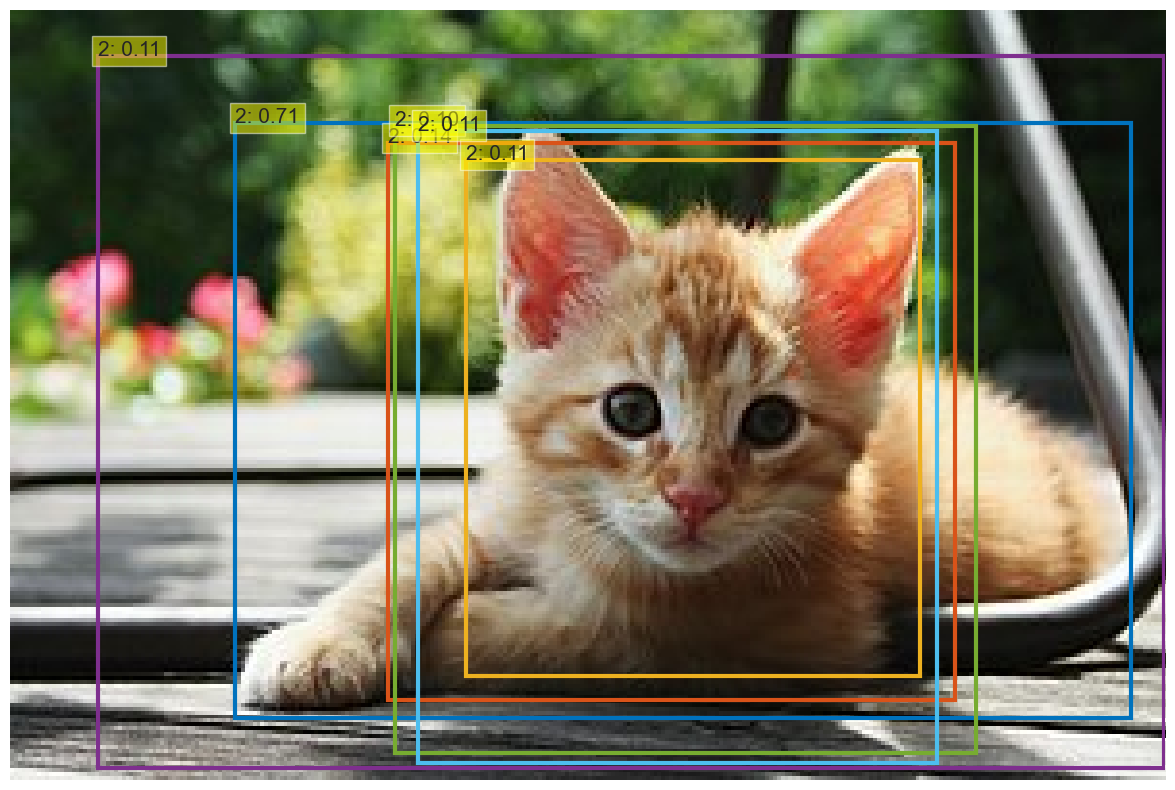

In [102]:
for results in postprocessed_outputs[:1]:
    plot_results(image, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())

In [78]:
postprocessed_outputs[:1]

[{'scores': tensor([0.7144, 0.1412, 0.1082, 0.1058, 0.1018, 0.1080], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2, 2], device='cuda:0'),
  'boxes': tensor([[ 58.0257,  28.9406, 290.7420, 183.2856],
          [ 97.5626,  34.1601, 244.9881, 178.6873],
          [117.8525,  38.4608, 235.7811, 172.5995],
          [ 22.3836,  11.5655, 299.3005, 196.3818],
          [ 99.5147,  29.6131, 250.4906, 192.4753],
          [105.4180,  30.9410, 240.3815, 195.1736]], device='cuda:0')}]